-----------------------------------------------------------------
# INM432 Big Data - Coursework 2
#### Implementing a Recommender System on the MovieLens 20M dataset
#### Adrian Ellis and Toby Staines
#### Code to be run on the newhaven server
-----------------------------------------------------------------

**1) Load the MovieLens dataset**

In [2]:
import pixiedust
import os
from time import time
import pandas as pd
import seaborn as sns
from pyspark.sql import SQLContext, Row
from pyspark.sql.types import *
from pyspark.sql.functions import avg, sqrt, col, udf, mean, stddev, count
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import QuantileDiscretizer

spark = SparkSession.builder.getOrCreate()

# load movie ratings data
ratings_data = 'hdfs://saltdean/data/movielens/ml-20m/ratings.csv'

# define schema (note that inferSchema="true" requires spark to read entire dataset)
ratings_fields = [('userID', IntegerType()), ('movieID', IntegerType()), 
                  ('rating', FloatType()), ('timestamp', IntegerType())]
# note nullable set to False. Leave timestamp as integer type as we are not using it
fields = [StructField(field_name, field_type, False) for
          field_name, field_type in ratings_fields]
schema = StructType(fields)

ratings = spark.read.load(ratings_data, format="csv", sep=",", schema=schema, header="true")
#note above function is documented under pyspark.sql.DataFrameReader()
ratings.drop('timestamp') # drop column as not required

# load movie titles data
movies_data = 'hdfs://saltdean/data/movielens/ml-20m/movies.csv'

# define schema
movies_fields = [('movieID', IntegerType()), ('title', StringType()), ('genres', StringType())]
fields = [StructField(field_name, field_type, False) for
          field_name, field_type in movies_fields]
schema = StructType(fields)

movies = spark.read.load(movies_data, format="csv", sep=",", schema=schema, header="true")
# note that delimiters inside the default ["] quote character are ignored which is what we want
movies.drop('timestamp')

Pixiedust database opened successfully


DataFrame[movieID: int, title: string, genres: string]

In [2]:
%%time
# check dataframes loaded properly
dfs = [ratings, movies]
counts = []
i = 0
for df in dfs:
    counts.append(df.count())
    i += 1
    print(df.dtypes)
    print(df.head(5))
    
# Sparsity = 1 - ratings count/(user count * movie count)
user_count = ratings.select('userID').distinct().count()
sparsity = 1 - (counts[0]/(user_count * counts[1]))
print('Movie count =',counts[1])
print('User count =',user_count)
print('Ratings count =',counts[0])
print('Sparsity =',round(sparsity*100,2),'%')

[('userID', 'int'), ('movieID', 'int'), ('rating', 'float'), ('timestamp', 'int')]
[Row(userID=1, movieID=2, rating=3.5, timestamp=1112486027), Row(userID=1, movieID=29, rating=3.5, timestamp=1112484676), Row(userID=1, movieID=32, rating=3.5, timestamp=1112484819), Row(userID=1, movieID=47, rating=3.5, timestamp=1112484727), Row(userID=1, movieID=50, rating=3.5, timestamp=1112484580)]
[('movieID', 'int'), ('title', 'string'), ('genres', 'string')]
[Row(movieID=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy'), Row(movieID=2, title='Jumanji (1995)', genres='Adventure|Children|Fantasy'), Row(movieID=3, title='Grumpier Old Men (1995)', genres='Comedy|Romance'), Row(movieID=4, title='Waiting to Exhale (1995)', genres='Comedy|Drama|Romance'), Row(movieID=5, title='Father of the Bride Part II (1995)', genres='Comedy')]
Movie count = 27278
User count = 138493
Ratings count = 20000263
Sparsity = 99.47 %
CPU times: user 44 ms, sys: 4 ms, total: 48 ms
Wall time: 

#### 2) Find best model using ALS and ML Pipeline
We will use Alternating Least Squares (ALS) to create a recommendation model using latent factors

We use the QuantileDiscretizer function to create a new movie rating scale, and feed this to ALS in a pipeline. We can then compare the results of models trained using both rating systems.

In [13]:
def ALSValidator(ratingCol):
    """
    Allows us to repeatedly create validated models
    """
    
    # Use discretizer to create a new ratings column
    discretizer = QuantileDiscretizer(numBuckets=3, inputCol="rating", outputCol="new_rating")
    
    # Define the base ALS model
    als = ALS(userCol="userID", itemCol="movieID", ratingCol=ratingCol,
              rank=10, maxIter=10, regParam=0.1, coldStartStrategy='drop', seed=0)

    # Create pipeline
    pipeline = Pipeline(stages=[discretizer, als])

    ## Build the validator for finding an optimal model ##
    # Set performance evaluator
    evaluator = RegressionEvaluator(metricName="rmse", labelCol=ratingCol,
                                    predictionCol="prediction")

    # Create parameter grid over ALS rank and regularisation parameter
    paramGrid = ParamGridBuilder()\
        .addGrid(als.rank,[1, 5, 10, 15, 20])\
        .addGrid(als.regParam,[0.1, 0.3, 0.5, 0.7, 0.9])\
        .build()

    # Set train/validation split
    validator = TrainValidationSplit(trainRatio=0.9, seed=0)\
                .setEstimator(pipeline).setEvaluator(evaluator).setEstimatorParamMaps(paramGrid)
    return validator, evaluator, paramGrid

In [4]:
def validationResults(validatedModel,parameterGrid, rating_type, sample_size):
    """
    Produces table of results from a grid search model validation
    """    
    # Create an empty data frame
    columns = ['Rating Type','Sample Size','RMSE','Normalised RMSE','Rank','Reg Param']
    results = pd.DataFrame(columns=columns)
    # Set a normalisation factor
    if rating_type == 'rating':
        norm_fact = 5
    elif rating_type == 'new_rating':
        norm_fact = 2
    i=0
    # For each parameter setting in the grid search
    for paramMap in parameterGrid:
        # Get the validation RMSE
        rmse = validatedModel.validationMetrics[i]
        norm = rmse/norm_fact
        i+=1
        d={}
        # For each parameter in the map, get the parameter name and value and put them in a dictionary
        for key in paramMap:
            param=key.name
            param_setting=paramMap[key]
            d[param] = param_setting
        # Create a data frame row of RMSE, Rank, and Regularisation Parameter
        row = pd.DataFrame([[rating_type, sample_size, rmse, norm, d['rank'],d['regParam']]], columns=columns)
        # Add the new row to the results table
        results = results.append(row, ignore_index=True)
    return results

In [18]:
# Execute experiment
# This is effectively a two layer grid search, one over rating type and sample size, and 
# within each of those models, another over rank and regularisation parameter.
sample_sizes = [0.0001, 0.001, 0.01, 0.1, 1.0]
model_list = [[],[]]
columns = ['Rating Type','Sample Size','RMSE','Normalised RMSE','Rank','Reg Param']
validation_results = pd.DataFrame(columns=columns)
train_rmse_list = [[],[]]
norm_train_rmse_list = [[],[]]
test_rmse_list = [[],[]]
norm_test_rmse_list = [[],[]]
train_time_list = [[],[]]
test_time_list = [[],[]]

# Take 10% of the data for test (still roughly 2,000,000 rows)
ratings_remainder, ratings_test = ratings.randomSplit([0.9,0.1]) 

for sample_size in sample_sizes:
    # From the remaining data, take a training sample
    ratings_train = ratings_remainder.sample(withReplacement=False, fraction=float(sample_size))
    i=0
    for rating in ('rating','new_rating'):
        validator, evaluator, paramGrid = ALSValidator(rating)
        # Train
        train_start = time()
        %time model = validator.fit(ratings_train)
        train_finish = time()
        model_list[i].append(model)
        train_time_list[i].append(train_finish - train_start)
        # Record validation results
        validation_results = validation_results.append(validationResults(model,paramGrid,rating,sample_size), ignore_index=True)
        # Evaluate the model
        train_rmse = evaluator.evaluate(model.transform(ratings_train))
        train_rmse_list[i].append(train_rmse)
        test_start = time()
        % time test_rmse = evaluator.evaluate(model.transform(ratings_test))
        test_finish = time()
        test_time_list[i].append(test_finish - test_start)
        test_rmse_list[i].append(test_rmse)
        # Normalise the results
        if rating == 'rating':
            norm_fact = 5
        elif rating == 'new_rating':
            norm_fact = 2
        norm_train_rmse_list[i].append(train_rmse/norm_fact)
        norm_test_rmse_list[i].append(test_rmse/norm_fact)
        i += 1

CPU times: user 10.9 s, sys: 4.15 s, total: 15 s
Wall time: 5min 57s
CPU times: user 760 ms, sys: 264 ms, total: 1.02 s
Wall time: 33.3 s
CPU times: user 7.24 s, sys: 2.9 s, total: 10.1 s
Wall time: 4min 13s
CPU times: user 612 ms, sys: 276 ms, total: 888 ms
Wall time: 32.2 s
CPU times: user 6.76 s, sys: 2.62 s, total: 9.37 s
Wall time: 4min 34s
CPU times: user 504 ms, sys: 144 ms, total: 648 ms
Wall time: 28.7 s
CPU times: user 7.5 s, sys: 3.16 s, total: 10.7 s
Wall time: 4min 29s
CPU times: user 872 ms, sys: 404 ms, total: 1.28 s
Wall time: 34.9 s
CPU times: user 11.8 s, sys: 4.42 s, total: 16.3 s
Wall time: 6min 33s
CPU times: user 684 ms, sys: 236 ms, total: 920 ms
Wall time: 32.9 s
CPU times: user 7.94 s, sys: 3.08 s, total: 11 s
Wall time: 5min 46s
CPU times: user 652 ms, sys: 276 ms, total: 928 ms
Wall time: 31.4 s
CPU times: user 20.2 s, sys: 9.07 s, total: 29.2 s
Wall time: 12min 9s
CPU times: user 760 ms, sys: 352 ms, total: 1.11 s
Wall time: 32.8 s
CPU times: user 18 s, sys:

In [19]:
# Reformat model level results  
columns = ['Rating Type','Sample Size','Train RMSE','Test RMSE',
           'Normalised Train RMSE','Normalised Test RMSE',
           'Train Time','Test Time']
final_results = pd.DataFrame(columns=columns)
i=0
j=0
for rating_type in ['0-5','0-2']:
    for size in sample_sizes:
        data = [rating_type, size, train_rmse_list[i][j], test_rmse_list[i][j], norm_train_rmse_list[i][j],
               norm_test_rmse_list[i][j], train_time_list[i][j], test_time_list[i][j]]
        row = pd.DataFrame([data], columns=columns)
        final_results = final_results.append(row, ignore_index=True)
        j += 1
    i += 1
    j = 0

# Save results tables to file
final_results.to_csv('Results.csv')
validation_results.to_csv('Validation_Results.csv')


In [22]:
# Display the results of each optimised model
final_results

,Rating Type,Sample Size,Train RMSE,Test RMSE,Normalised Train RMSE,Normalised Test RMSE,Train Time,Test Time
0,0-5,0.0001,0.067753,3.851903,0.013551,0.770381,357.177402,33.280585
1,0-5,0.0010,0.932514,3.657787,0.186503,0.731557,274.069499,28.747549
2,0-5,0.0100,0.754276,1.179457,0.150855,0.235891,393.637302,32.936442
3,0-5,0.1000,0.828651,0.909805,0.165730,0.181961,729.472953,32.849063
4,0-5,1.0000,0.777424,0.805399,0.155485,0.161080,2447.796975,32.277814
5,0-2,0.0001,0.089438,1.574446,0.044719,0.787223,253.666170,32.246799
6,0-2,0.0010,0.907665,1.485587,0.453832,0.742793,269.423333,34.883843
7,0-2,0.0100,0.484294,0.835033,0.242147,0.417516,346.211740,31.366062
8,0-2,0.1000,0.532176,0.656740,0.266088,0.328370,710.671868,37.669535
9,0-2,1.0000,0.603477,0.613772,0.301738,0.306886,2239.924758,30.024852


In [25]:
# Display the head of the full parameter grid results table. The table has 250 rows and is available as a csv.
validation_results.head(10)

,Rating Type,Sample Size,RMSE,Normalised RMSE,Rank,Reg Param
0,rating,0.0001,4.698271,0.939654,1,0.1
1,rating,0.0001,5.255293,1.051059,1,0.3
2,rating,0.0001,5.164303,1.032861,1,0.5
3,rating,0.0001,5.003830,1.000766,1,0.7
4,rating,0.0001,4.837561,0.967512,1,0.9
5,rating,0.0001,2.999444,0.599889,5,0.1
6,rating,0.0001,2.884596,0.576919,5,0.3
7,rating,0.0001,2.841140,0.568228,5,0.5
8,rating,0.0001,2.826586,0.565317,5,0.7
9,rating,0.0001,2.829039,0.565808,5,0.9


In [102]:
# Identify the optimum parameter settings for each combination of sample size and ratings type
min_rmse = validation_results.groupby(['Rating Type','Sample Size'])['Normalised RMSE'].min().to_frame()
opt_params = min_rmse.merge(validation_results, on='Normalised RMSE')
opt_params

,Normalised RMSE,Rating Type,Sample Size,RMSE,Rank,Reg Param
0,0.273586,new_rating,0.0001,0.547172,10,0.1
1,0.750911,new_rating,0.0010,1.501821,20,0.9
2,0.423693,new_rating,0.0100,0.847385,15,0.3
3,0.330739,new_rating,0.1000,0.661478,5,0.1
4,0.306944,new_rating,1.0000,0.613888,15,0.1
5,0.491739,rating,0.0001,2.458694,10,0.1
6,0.726721,rating,0.0010,3.633607,15,0.9
7,0.239722,rating,0.0100,1.198608,15,0.5
8,0.182667,rating,0.1000,0.913336,1,0.1
9,0.161159,rating,1.0000,0.805793,10,0.1


#### 3) Test ALS model (without pipeline)

We implement the best model without a pipeline so we can explore the results qualitatively by calling methods of the ALS Model (note when using a pipeline we don't seem to have access to these methods as a Pipeline Model object is returned). For this we use the optimum parameters discovered in part 2, and the same training and test data.


In [4]:
# Define a function to translate 0-5 rating into 0-2, as per QuantileDisretizer above
def transformRatings(rating):
    if rating < 2.5:
        new_rating = 0
    elif rating >= 4:
        new_rating = 2
    else:
        new_rating = 1
    return new_rating

# Define SQL UDF
ratingsTransformer = udf(transformRatings,IntegerType())
# Create new ratings column
ratings_remainder = ratings_remainder.withColumn('new_rating', ratingsTransformer(ratings_remainder['rating']))
ratings_test = ratings_test.withColumn('new_rating', ratingsTransformer(ratings_test['rating']))

In [5]:
als = ALS(userCol="userID", itemCol="movieID", ratingCol="rating",
          rank=10, maxIter=10, regParam=0.1, coldStartStrategy='drop', seed=0)
          # use coldStartStrategy='drop' above to avoid 'nan' values for IDs not seen in training data
    
# Fit the model
# Since the best result was achieved with sample size of 1, there is no need to take a training sample
%time model=als.fit(ratings_remainder) 

CPU times: user 36 ms, sys: 12 ms, total: 48 ms
Wall time: 1min 32s


#### 3.1) Evaluate the prediction results

In [29]:
# Predict ratings for the test set
%time predictions = model.transform(ratings_test)
predictions.head(5)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 17.6 ms


[Row(userID=88527, movieID=148, rating=2.0, timestamp=965659724, new_rating=0, prediction=2.2405357360839844),
 Row(userID=125969, movieID=148, rating=3.0, timestamp=940129037, new_rating=1, prediction=3.000100612640381),
 Row(userID=111523, movieID=148, rating=2.0, timestamp=942665835, new_rating=0, prediction=3.228667736053467),
 Row(userID=20344, movieID=148, rating=2.0, timestamp=965940170, new_rating=0, prediction=2.5461130142211914),
 Row(userID=109910, movieID=148, rating=2.0, timestamp=907093395, new_rating=0, prediction=2.2334816455841064)]

In [30]:
# Calculate summary statistics for the predictions
from pyspark.sql.functions import mean, stddev
predictions.select(stddev(col='prediction'), mean(col='prediction')).collect()

prediction_stats = predictions.select(mean(col('rating')).alias('rating_mean'), 
                                      stddev(col('rating')).alias('rating_std'),
                                      mean(col('prediction')).alias('pr_mean'), 
                                      stddev(col('prediction')).alias('pr_std')).collect()

prediction_stats

[Row(rating_mean=3.5251956392884205, rating_std=1.052758930793167, pr_mean=3.4224365413224747, pr_std=0.6331939881308019)]

In [31]:
# Join ratings with movie title
predictions = predictions.join(movies, predictions.movieID == movies.movieID, 'inner') \
                         .select('userID', 'title', 'rating', 'prediction')
predictions.show(5, truncate = False)

+------+--------------------------------+------+----------+
|userID|title                           |rating|prediction|
+------+--------------------------------+------+----------+
|88527 |Awfully Big Adventure, An (1995)|2.0   |2.2405357 |
|125969|Awfully Big Adventure, An (1995)|3.0   |3.0001006 |
|111523|Awfully Big Adventure, An (1995)|2.0   |3.2286677 |
|20344 |Awfully Big Adventure, An (1995)|2.0   |2.546113  |
|109910|Awfully Big Adventure, An (1995)|2.0   |2.2334816 |
+------+--------------------------------+------+----------+
only showing top 5 rows



In [32]:
## Qualitative results
# Show predictions vs. ratings for first userID
firstID = predictions.first().userID
firstDF = predictions.filter(predictions.userID == firstID)
firstDF.show(truncate=False)

# Show top 10 recommendations for first userID
firstRecs = model.recommendForUserSubset(firstDF, 10).select('recommendations')
firstRecs.collect()

+------+-------------------------------------------------+------+----------+
|userID|title                                            |rating|prediction|
+------+-------------------------------------------------+------+----------+
|88527 |Awfully Big Adventure, An (1995)                 |2.0   |2.2405357 |
|88527 |Devil's Advocate, The (1997)                     |4.0   |2.9027505 |
|88527 |That Darn Cat (1997)                             |1.0   |1.7179686 |
|88527 |Awakenings (1990)                                |4.0   |3.3376021 |
|88527 |Road Warrior, The (Mad Max 2) (1981)             |5.0   |3.4045696 |
|88527 |Chill Factor (1999)                              |3.0   |1.6282623 |
|88527 |Benny & Joon (1993)                              |3.0   |2.756366  |
|88527 |Devil and Max Devlin, The (1981)                 |1.0   |2.0451646 |
|88527 |Pete's Dragon (1977)                             |1.0   |2.459177  |
|88527 |Name of the Rose, The (Name der Rose, Der) (1986)|3.0   |3.471846  |

[Row(recommendations=[Row(movieID=121029, rating=4.94553279876709), Row(movieID=101855, rating=4.826445579528809), Row(movieID=81117, rating=4.804771900177002), Row(movieID=85205, rating=4.792248249053955), Row(movieID=101717, rating=4.714137554168701), Row(movieID=112473, rating=4.713104248046875), Row(movieID=116183, rating=4.691162109375), Row(movieID=41980, rating=4.676316738128662), Row(movieID=101706, rating=4.648225784301758), Row(movieID=3226, rating=4.644798278808594)])]

In [33]:
# Add a new column for squared error
predictions = predictions.withColumn('squared_error', (predictions.rating - predictions.prediction)**2)

# Group by user and calculate RMSE for each. We can now look for relationships between review count and error.
gr = predictions.groupby('userID')
users = gr.agg(count(col('rating')).alias('num_ratings'), mean(col('squared_error')).alias('MSE'))
users = users.withColumn('RMSE', sqrt(users['MSE']))
users.show(5, truncate = False)

+------+-----------+-------------------+------------------+
|userID|num_ratings|MSE                |RMSE              |
+------+-----------+-------------------+------------------+
|137501|100        |1.102576004476802  |1.0500361919842582|
|4818  |5          |0.32866860978091383|0.5732962670216106|
|65251 |20         |0.968446099272839  |0.9840965904182571|
|134138|84         |0.8467627011101538 |0.920197099055498 |
|24347 |48         |0.4827282110860433 |0.6947864499873636|
+------+-----------+-------------------+------------------+
only showing top 5 rows



#### 4) Plotting

In [46]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

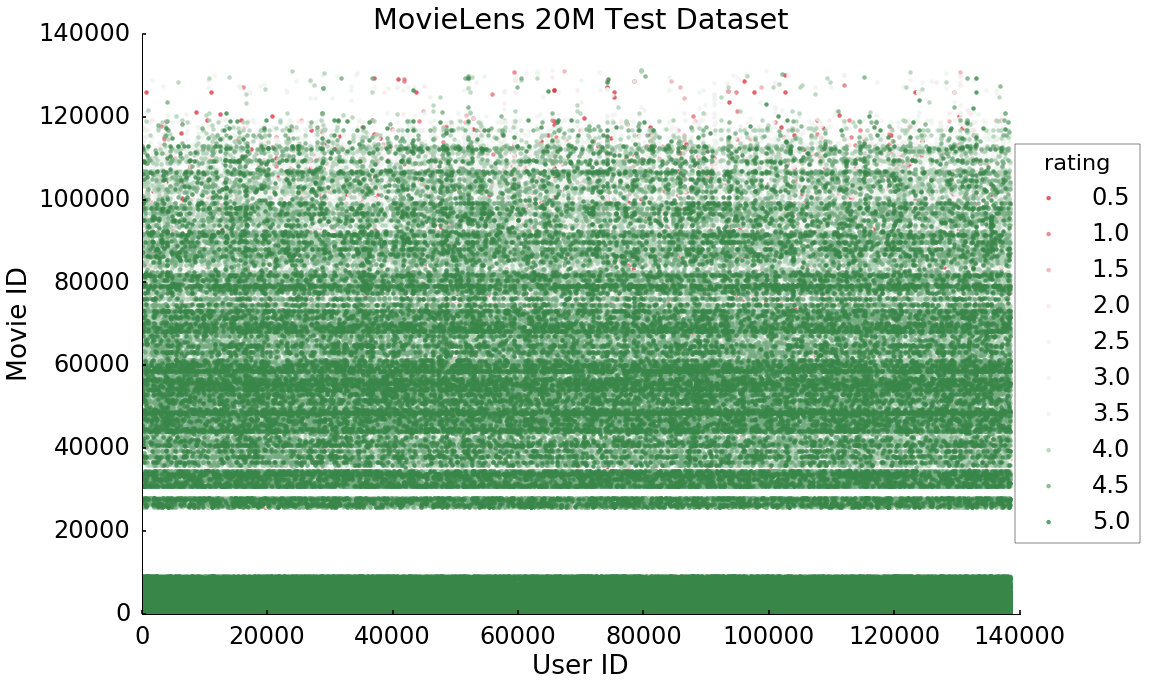

In [38]:
# Plot of the data set
ratingsPandas = ratings_test.toPandas()

sns.set_context("poster", font_scale=1.5)
lm = sns.lmplot(x='userID', y='movieID', hue='rating', 
                data=ratingsPandas, fit_reg=False, size=10, 
                aspect=1.5, palette=sns.diverging_palette(10, 133, sep=80, n=10))
axes = lm.axes
axes[0,0].set_ylim(0,140000) 
axes[0,0].set_xlim(0,140000) 
axes[0,0].set_title('MovieLens 20M Test Dataset')
axes[0,0].set_ylabel('Movie ID')
axes[0,0].set_xlabel('User ID')

lm

In [52]:
# Put data into Pandas df for ease of use
usersPandas = users.toPandas()

# Compute correlation statistics
p = stats.pearsonr(usersPandas['num_ratings'],usersPandas['RMSE'])
s = stats.spearmanr(usersPandas['num_ratings'],usersPandas['RMSE'])
print(s,p)

SpearmanrResult(correlation=0.06416870227393473, pvalue=1.0148659542538096e-123) (-0.01807115264169946, 2.818180284432305e-11)


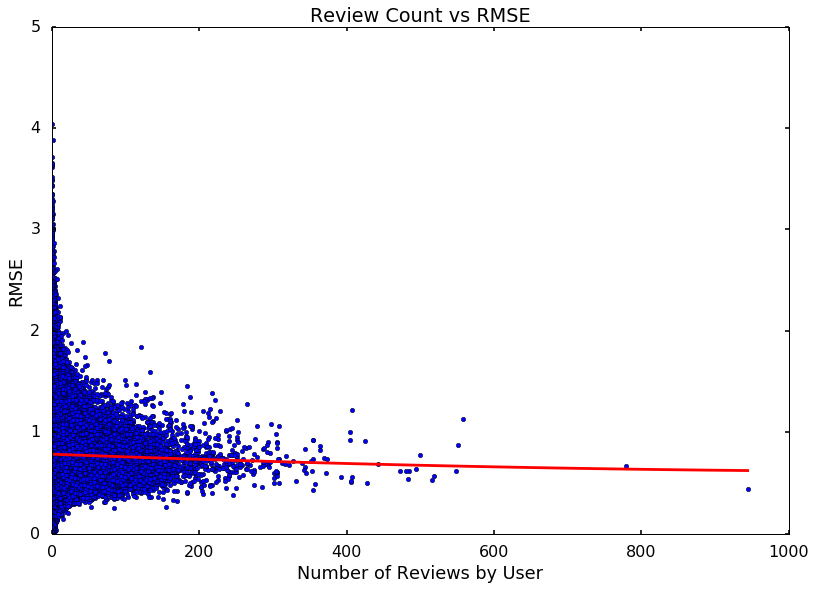

In [53]:
# Create a polynomial regression line for the plot
xp = np.linspace(usersPandas['num_ratings'].min(), usersPandas['num_ratings'].max(), 100)
pCoeff = np.polyfit(usersPandas['num_ratings'],usersPandas['RMSE'], 2)
evaluatedCurve = np.polyval(pCoeff, usersPandas['num_ratings'])
regLine = np.poly1d(pCoeff)


# Plot user review count vs individual RMSE
plt.style.use('seaborn-poster')
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.set_xlim(0,1000) 
axes.set_ylim(0,5) 
plt.scatter(usersPandas['num_ratings'],usersPandas['RMSE'])
plt.plot(xp,regLine(xp), 'r--')
axes.set_title('Review Count vs RMSE')
axes.set_xlabel('Number of Reviews by User')
axes.set_ylabel('RMSE')

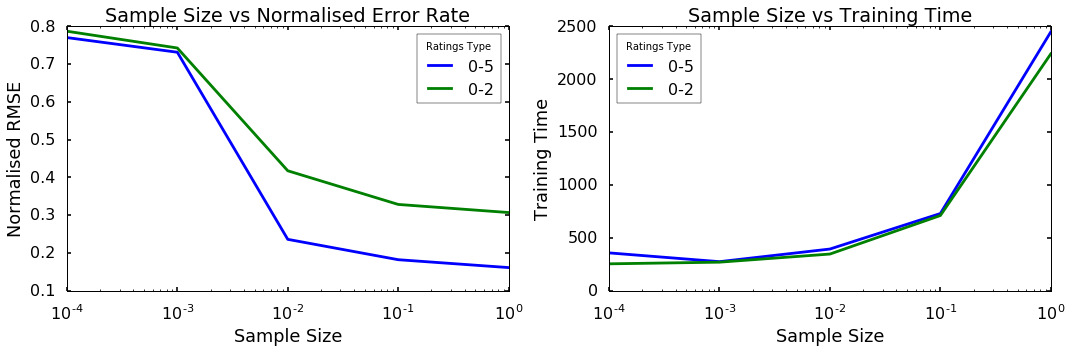

In [112]:
# Plot of error rate and training time against sample size

plt.style.use('seaborn-poster')
fig, ax = plt.subplots(1,2, figsize=(15,5))

# Error rate subplot
ax[0].plot(final_results['Sample Size'][final_results['Rating Type']=='0-5'], 
           final_results['Normalised Test RMSE'][final_results['Rating Type']=='0-5'])
ax[0].plot(final_results['Sample Size'][final_results['Rating Type']=='0-2'], 
           final_results['Normalised Test RMSE'][final_results['Rating Type']=='0-2'])
ax[0].set_title('Sample Size vs Normalised Error Rate')
ax[0].set_xlabel('Sample Size')
ax[0].set_xscale('log')
ax[0].set_ylabel('Normalised RMSE')
ax[0].legend(["0-5", "0-2"], title='Ratings Type')

# Training time subplot
ax[1].plot(final_results['Sample Size'][final_results['Rating Type']=='0-5'], 
           final_results['Train Time'][final_results['Rating Type']=='0-5'])
ax[1].plot(final_results['Sample Size'][final_results['Rating Type']=='0-2'], 
           final_results['Train Time'][final_results['Rating Type']=='0-2'])
ax[1].set_title('Sample Size vs Training Time')
ax[1].set_xlabel('Sample Size')
ax[1].set_xscale('log')
ax[1].set_ylabel('Training Time')
ax[1].legend(["0-5", "0-2"], title='Ratings Type', loc=2)

fig.tight_layout()
plt.show()

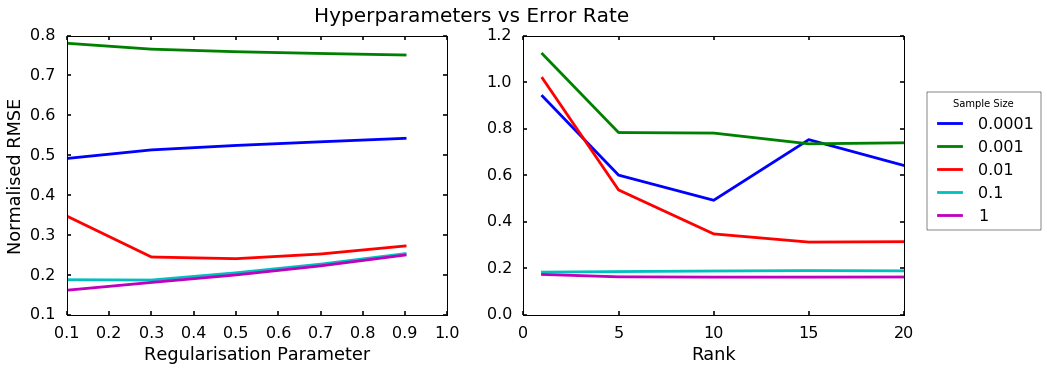

In [131]:
# Plot of hyperparameters against error rate

# Regularisation will be plotted for the best performing overall rank (10)
rank10 = validation_results[(validation_results['Rank']==10)&(validation_results['Rating Type']=='rating')]
# Rank will be plotted for the best performing overall regularisation (0.1)
regPoint1 = validation_results[(validation_results['Reg Param']==0.1)&(validation_results['Rating Type']=='rating')] 

sample_sizes = [0.0001, 0.001, 0.01, 0.1, 1.0]
fig, ax = plt.subplots(1,2, figsize=(15,5))

# Regularisation subplot
for size in sample_sizes:
    subset = rank10[rank10['Sample Size']==size]
    ax[0].plot(subset['Reg Param'], subset['Normalised RMSE'])
ax[0].set_xlabel('Regularisation Parameter')
ax[0].set_ylabel('Normalised RMSE')

# Rank subplot
for size in sample_sizes:
    subset = regPoint1[regPoint1['Sample Size']==size]
    ax[1].plot(subset['Rank'], subset['Normalised RMSE'])
ax[1].set_xlabel('Rank')
plt.suptitle('Hyperparameters vs Error Rate', fontsize=20)

plt.legend(['0.0001','0.001','0.01','0.1','1'], title='Sample Size', bbox_to_anchor=(1.04, 0.55), loc=6)



In [119]:
rank10

,Rating Type,Sample Size,RMSE,Normalised RMSE,Rank,Reg Param
10,rating,0.0001,2.458694,0.491739,10,0.1
11,rating,0.0001,2.566062,0.513212,10,0.3
12,rating,0.0001,2.622034,0.524407,10,0.5
13,rating,0.0001,2.667741,0.533548,10,0.7
14,rating,0.0001,2.711250,0.542250,10,0.9
52,rating,0.0010,3.903742,0.780748,10,0.1
57,rating,0.0010,3.829865,0.765973,10,0.3
62,rating,0.0010,3.797747,0.759549,10,0.5
67,rating,0.0010,3.775732,0.755146,10,0.7
72,rating,0.0010,3.756566,0.751313,10,0.9


In [123]:
regPoint1

,Rating Type,Sample Size,RMSE,Normalised RMSE,Rank,Reg Param
0,rating,0.0001,4.698271,0.939654,1,0.1
5,rating,0.0001,2.999444,0.599889,5,0.1
10,rating,0.0001,2.458694,0.491739,10,0.1
15,rating,0.0001,3.762349,0.752470,15,0.1
20,rating,0.0001,3.206990,0.641398,20,0.1
50,rating,0.0010,5.604603,1.120921,1,0.1
51,rating,0.0010,3.915102,0.783020,5,0.1
52,rating,0.0010,3.903742,0.780748,10,0.1
53,rating,0.0010,3.672740,0.734548,15,0.1
54,rating,0.0010,3.694771,0.738954,20,0.1
